# **Modelling and Evaluation version 2**

## Objectives

* Simplify the pipeline from the previous notebook to limit it to the most important features only.

## Inputs

* outputs/datasets/collection/house_prices_records.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict sale price
* Feature importance plot

## Additional Comments

* Full details and narrative text for the development of this ML pipeline can befound in Modelling_and_Evaluation_v1. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


## ML Pipeline: Regression

Create ML pipeline - simplified to include only transformations on the most important feratures, as determined in the previous notebook.

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt'])),

        ("CategoricalImputation", CategoricalImputer(imputation_method='missing',fill_value='Unf', 
                                                        variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', 
                                                variables=['LotFrontage', '2ndFlrSF', 'MasVnrArea'])),

        ("MeanImputation", MeanMedianImputer(imputation_method='mean', variables='BedroomAbvGr')),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['LotArea', 'LotFrontage'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['BsmtUnfSF', 'OpenPorchSF'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables='TotalBsmtSF')),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, 
                                                                selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Create custom class for hyperparameter optimisation. (Modified from CI Churnometer project)

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test Sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Define ML model parameters

In [8]:
# Full grid search and hyperparameter optimisation were carried out in version 1 of this notebook.

models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
  "ExtraTreesRegressor":{'model__n_estimators': [200],
                          'model__max_features': [0.3],
                          'model__max_depth': [None],
                          'model__min_samples_split': [5],
  }
}


In [9]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/select

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.708021,0.802497,0.851729,0.060703,None,0.3,5,200


In [11]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

In [12]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__max_features': 0.3,
 'model__min_samples_split': 5,
 'model__n_estimators': 200}

In [13]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageYrBlt'])),
                ('CategoricalImputation',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables=['LotFrontage', '2ndFlrSF',
                                              'MasVnrArea'])),
                ('MeanImputation',
                 MeanMedianImputer(imputation...
                                                     'GrLivArea', 'KitchenQual',
                                                     'LotArea', 'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                             

Assess feature importance

* These are the 6 most important features in descending order. The model was trained on them: 
['GrLivArea', '1stFlrSF', 'GarageArea', 'YearRemodAdd', 'KitchenQual', 'YearBuilt']


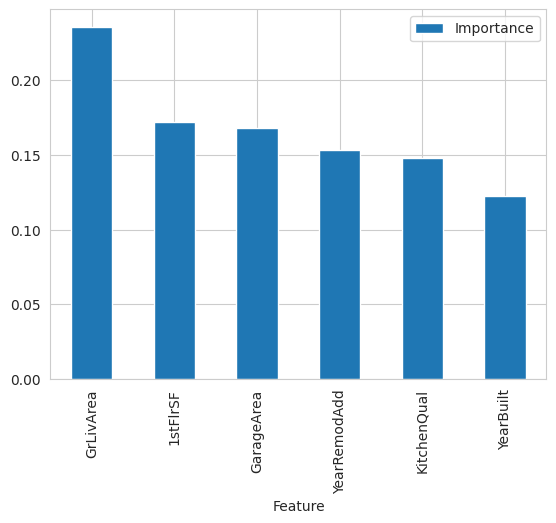

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 9 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


Evaluate on Train and Test Sets

In [15]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    print(X_train.shape, X_test.shape)
    print(y_train.shape, y_test.shape)
    
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    print(pred_train.shape, pred_test.shape)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.943
Mean Absolute Error: 11951.037
Mean Squared Error: 350363460.606
Root Mean Squared Error: 18717.998


* Test Set
R2 Score: 0.825
Mean Absolute Error: 21006.905
Mean Squared Error: 1207418447.811
Root Mean Squared Error: 34747.927


(1168, 23) (292, 23)
(1168,) (292,)
(1168,) (292,)


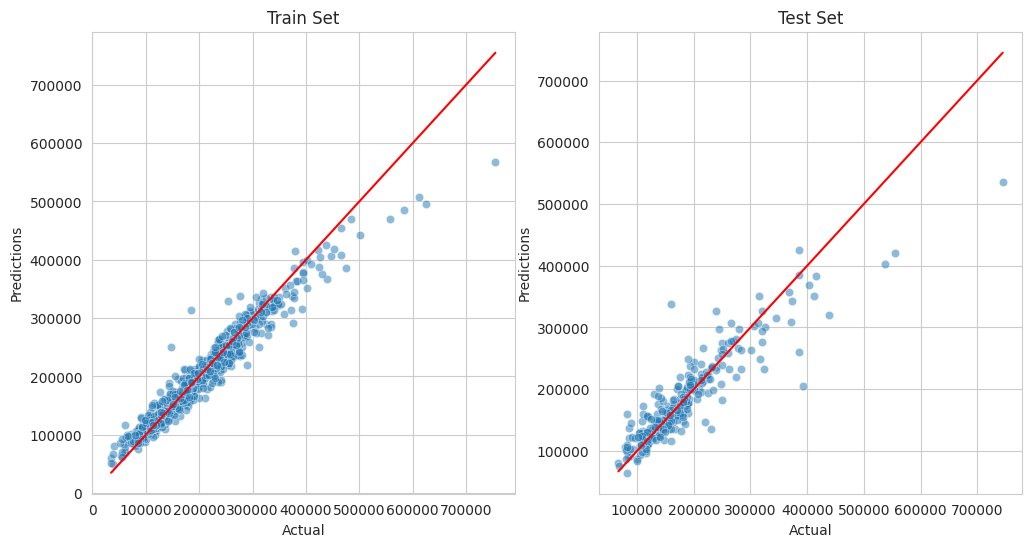

In [16]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## Rewrite simplified ML pipeline with only most important features

In [17]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        # ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt'])),

        # ("CategoricalImputation", CategoricalImputer(imputation_method='missing',fill_value='Unf', 
        #                                                 variables=['GarageFinish','BsmtFinType1'])),
        
        # ("MedianImputation", MeanMedianImputer(imputation_method='median', 
        #                                         variables=['LotFrontage', '2ndFlrSF', 'MasVnrArea'])),

        # ("MeanImputation", MeanMedianImputer(imputation_method='mean', variables='BedroomAbvGr')),

        # Feature Engineering - see Feature Engineering Notebook
        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
        #                                              variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
         ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['KitchenQual'])),

        # ("LogTransformer", vt.LogTransformer(variables=['LotArea', 'LotFrontage'])),

        # ("PowerTransformer", vt.PowerTransformer(variables=['BsmtUnfSF', 'OpenPorchSF'])),

        # ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables='TotalBsmtSF')),
                                      
        # ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, 
        #                                                         selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        # ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [18]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 6) (1168,) 
* Test set: (292, 6) (292,)


,1stFlrSF,GarageArea,GrLivArea,KitchenQual,YearBuilt,YearRemodAdd
618,1828,774,1828,Gd,2007,2007
870,894,308,894,TA,1962,1962
92,964,432,964,TA,1921,2006


In [19]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [21]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.719922,0.802508,0.851729,0.055369,None,0.3,5,200


In [22]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [23]:
pipeline_regression = grid_search_pipelines[best_model].best_estimator_
pipeline_regression

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features=0.3, min_samples_split=5,
                                     n_estimators=200, random_state=0))])

Model Evaluation 

* Train Set
R2 Score: 0.943
Mean Absolute Error: 11951.037
Mean Squared Error: 350363460.606
Root Mean Squared Error: 18717.998


* Test Set
R2 Score: 0.825
Mean Absolute Error: 21006.905
Mean Squared Error: 1207418447.811
Root Mean Squared Error: 34747.927


(1168, 6) (292, 6)
(1168,) (292,)
(1168,) (292,)


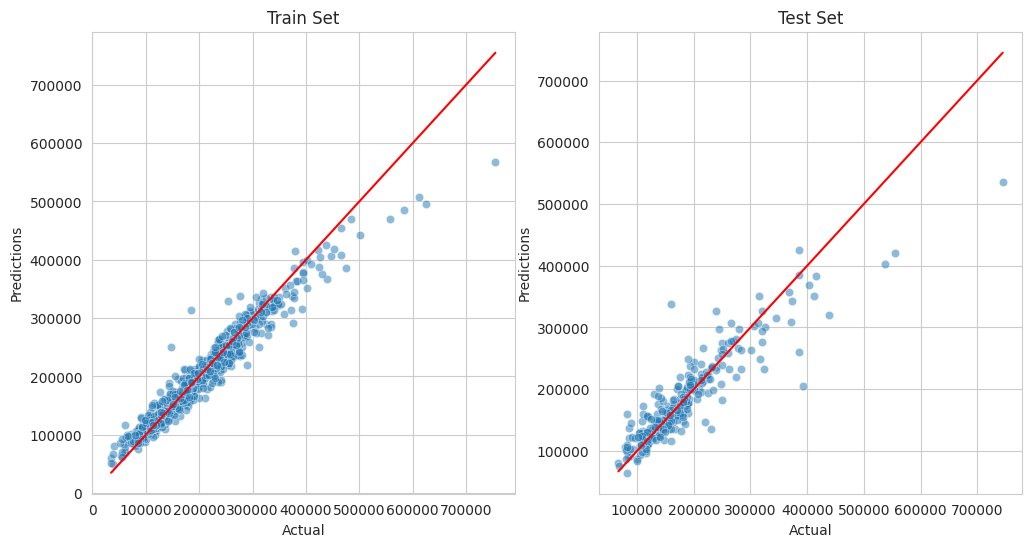

In [24]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_regression)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)

## Summary
* The pipeline has been rewritten to remove transformations on all but the most important features. In this case, the only transformation that was needed is Ordinal Encoding on the Kitchen Quality feature. All other data cleaning and feature engineering steps from the original pipeline affected features that are not used to train the model.
* The simplified version of the pipeline retains the same level of performance as the original pipeline.


---

# Push files to Repo

Generate the following files:
* Train Set
* Test Set
* Modelling Pipeline
* Feature importance Plot

In [25]:
import joblib
import os

version = 'v2'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)


### Train Set: Features and Target

In [26]:
X_train.head()

,1stFlrSF,GarageArea,GrLivArea,KitchenQual,YearBuilt,YearRemodAdd
618,1828,774,1828,Gd,2007,2007
870,894,308,894,TA,1962,1962
92,964,432,964,TA,1921,2006
817,1689,857,1689,Gd,2002,2002
302,1541,843,1541,Gd,2001,2002


In [27]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [28]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [29]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: Features and Target

In [30]:
X_test.head()

,1stFlrSF,GarageArea,GrLivArea,KitchenQual,YearBuilt,YearRemodAdd
529,2515,484,2515,TA,1957,1975
491,958,240,1578,Fa,1941,1950
459,979,352,1203,Gd,1950,1950
279,1156,505,2022,TA,1977,1977
655,525,264,1092,TA,1971,1971


In [31]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [32]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [33]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Modelling Pipeline

In [34]:
pipeline_regression

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features=0.3, min_samples_split=5,
                                     n_estimators=200, random_state=0))])

In [35]:
joblib.dump(value=pipeline_regression, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v2/regression_pipeline.pkl']

### Feature Importance Plot

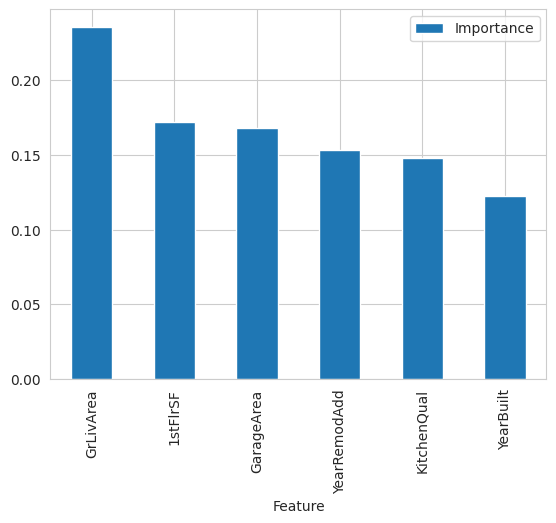

In [36]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

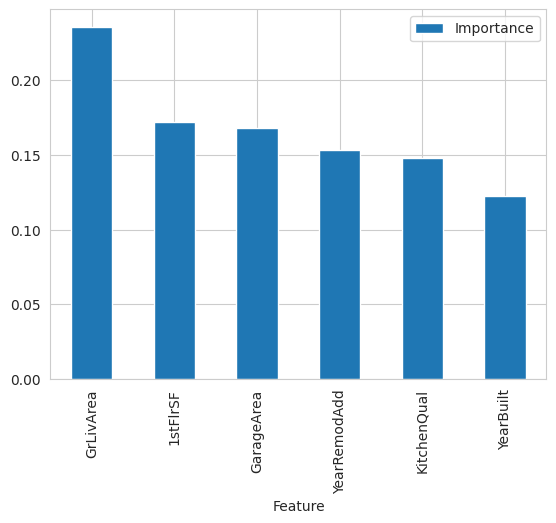

In [37]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

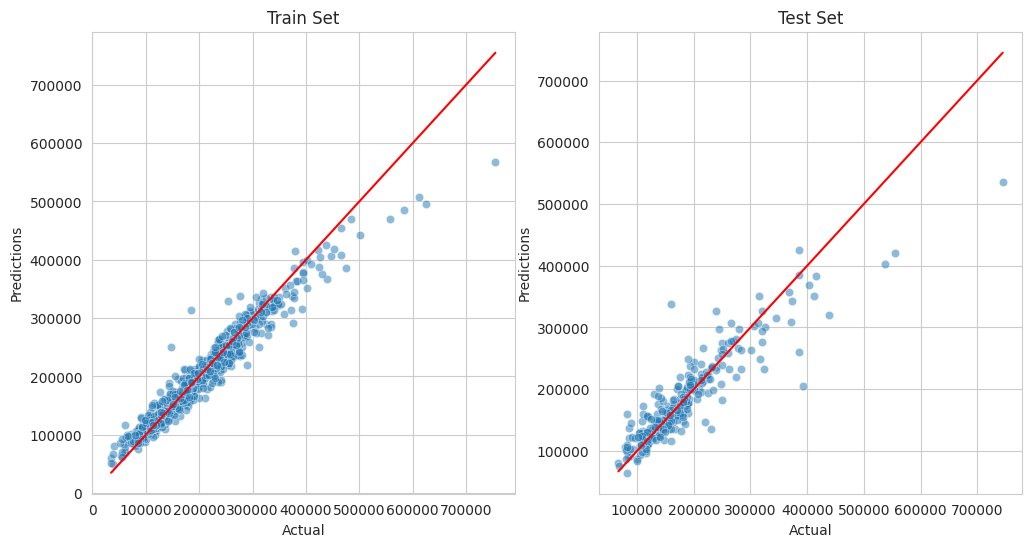

In [38]:
def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    # plt.show()
    plt.savefig(f'{file_path}/model_performance_evaluation.png', bbox_inches='tight')

regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)